In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import gym_pusht


def make_env(differential_action=False, render_mode='rgb_array', pixels_based_success=False):
    # Adjust the env_id if you are using a specific repo 
    # (e.g., 'gym_pusht/PushT-v0' or a local import like PushTImageEnv)
    ENV_ID = "gym_pusht/PushT-v0"

    try:
        # We use render_mode='human' to see the replay live, 
        # or 'rgb_array' if you want to save frames.
        env = gym.make(ENV_ID, render_mode=render_mode, differential_action=differential_action, observation_width=64, observation_height=64, pixels_based_success=pixels_based_success)
        # env = gym.make(ENV_ID, render_mode="rgb_array")
        
        print(f"Successfully created environment: {ENV_ID}")
        
        # Reset to check if it works
        obs, info = env.reset()
        
    except Exception as e:
        print(f"Error creating environment: {e}")
        print("Ensure gym-pusht is installed or adjust the ENV_ID.")
        # print out the environments that gym is aware of
        print("Available environments:", gym.envs.registry.keys())
        env=None
    return env


In [3]:
def inspect_zarr_file(zarr_path):
    """
    Opens the Zarr file and prints the tree structure 
    to help identify the keys for states, actions, and images.
    """
    try:
        root = zarr.open(zarr_path, mode='r')
        print(f"Opened Zarr file at: {zarr_path}")
        print("-" * 20)
        print(root.tree())
        return root
    except Exception as e:
        print(f"Failed to load Zarr file. Download from https://diffusion-policy.cs.columbia.edu/data/training/ : {e}.")

        return None

# Replace with your actual path
ZARR_PATH = "/home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr"
root = inspect_zarr_file(ZARR_PATH)

Opened Zarr file at: /home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr
--------------------
/
 ├── data
 │   ├── action (25650, 2) float32
 │   ├── img (25650, 96, 96, 3) float32
 │   ├── keypoint (25650, 9, 2) float32
 │   ├── n_contacts (25650, 1) float32
 │   └── state (25650, 5) float32
 └── meta
     └── episode_ends (206,) int64


Loaded 206 episodes.


/home/j/workspace/dreamerv3-torch/venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
diff position +89.80


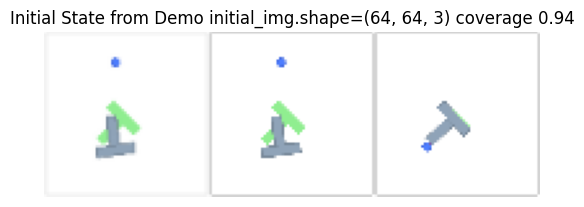

Episode replay complete. info['coverage']=0.9390295795726028 vs pixel coverage 0.93. Total reward: 52.07. info['is_success']=False


In [4]:
import collections

def load_pusht_demos(zarr_path):
    """
    Loads actions and states from Zarr and splits them into episodes
    based on 'meta/episode_ends'.
    """
    root = zarr.open(zarr_path, mode='r')
    
    # Load raw flattened arrays
    all_actions = root['data/action'][:]
    all_states = root['data/state'][:]
    episode_ends = root['meta/episode_ends'][:]
    
    episodes = []
    start_idx = 0
    
    for end_idx in episode_ends:
        # Slice the data for this specific episode
        episode_data = {
            'action': all_actions[start_idx:end_idx],
            'state': all_states[start_idx:end_idx],
            # We don't strictly need images for replay (we can render live), 
            # but you can load them here if needed:
            'img': root['data/img'][start_idx:end_idx],
            'keypoint': root['data/keypoint'][start_idx:end_idx]
        }
        episodes.append(episode_data)
        start_idx = end_idx
        
    print(f"Loaded {len(episodes)} episodes.")
    return episodes

import time
def replay_demo(env, episode_data, fps=60, differential_action=False):
    """
    Resets the environment to the demo's initial state and replays actions.
    """
    
    # 2. Force the environment state to match the demo's first frame.
    #    The state usually contains [agent_x, agent_y, block_x, block_y, block_theta].
    #    Without this, the block will be in a random spot and the actions won't make sense.
    initial_state = episode_data['state'][0]

    # 1. Reset environment for the wrappers and then for the initial state
    env.reset()
    obs, info = env.unwrapped.reset(options={"reset_to_state": initial_state})
    for _ in range(100): # takes time to arrive at the target state
        env.unwrapped._set_state(initial_state)
    env_img = env.render()
    # print(f"{initial_state=}")
    # show the initial image in episode_data
    initial_img = episode_data['img'][0].astype(np.uint8)
    final_img = episode_data['img'][-1].astype(np.uint8)

    print(f'diff position {np.linalg.norm(obs - initial_state):+1.2f}')

    # 3. Execute actions
    actions = episode_data['action']

    total_reward = 0
    
    if differential_action:
        # The difference between the consecutive agent positions is our differential action
        states = episode_data['state']; state_idx = 1;nsteps=0
        target_state = states[state_idx]; target_state_threshold = 1.0
        def close_enough(a, b, thresh):
            return np.linalg.norm(a - b) < thresh
        while True:
            action = target_state[0:2] - env.unwrapped.agent.position
            obs, reward, terminated, truncated, info = env.step(action); nsteps+=1
            
            success = info['is_success'] if 'is_success' in info else False
            reward += 300. if success else 0. # numsteps
            
            total_reward += reward
            env.render()

            if close_enough(env.unwrapped.agent.position, target_state[0:2], target_state_threshold):
                state_idx += 1
                if state_idx < len(states):
                    target_state = states[state_idx]
                else:
                    break
        
        print(f"Total steps taken: {nsteps}, demo length: {len(states)}")
        # repeat the last action
        env.step(action)
    else:
        for action in actions:
            # Step the environment
            obs, reward, terminated, truncated, info = env.step(action)

            success = info['is_success'] if 'is_success' in info else False
            reward += 300. if success else 0. # numsteps

            total_reward += reward
            final_env_img = env.render()
            
            # Render is handled automatically by render_mode='human' in env creation
            # If you need to slow it down to be viewable:
            # plt.pause(1/fps) 
            # time.sleep(1/fps)

        # add one more action that's the same as the last action, since these demonstrations seem to end a step early
        obs, reward, terminated, truncated, info = env.step(actions[-1])
        total_reward += reward
        # for _ in range(2):
        #     obs, reward, terminated, truncated, info = env.step(actions[-1])

    final_env_img = env.render()
    toshow = np.hstack([initial_img, env_img, final_env_img])
    plt.imshow(toshow)
    plt.axis('off')
    plt.title(f"Initial State from Demo {initial_img.shape=} coverage {info['coverage']:1.2f}")
    plt.show(block=False)
    pixel_coverage = env.unwrapped._get_pixel_coverage()
    print(f"Episode replay complete. {info['coverage']=} vs pixel coverage {pixel_coverage:1.2f}. Total reward: {total_reward:1.2f}. {info['is_success']=}")

    return info['coverage'], pixel_coverage

# --- Usage ---
import copy, collections

differential_action = False

# 1. Load the episodes
demos = load_pusht_demos(ZARR_PATH)

env = make_env(differential_action=differential_action, pixels_based_success=True)
# resize the images if the env observation size is different from the demo image size
if env.unwrapped.observation_width != demos[0]['img'].shape[1] or env.unwrapped.observation_height != demos[0]['img'].shape[2]:
    for ep in demos:
        img = ep['img']
        if img.shape[1] != 64 or img.shape[2] != 64:
            from skimage.transform import resize
            resized_imgs = []
            for im in img:
                im_resized = resize(im, (64, 64), preserve_range=True).astype(np.uint8)
                resized_imgs.append(im_resized)
            ep['img'] = np.array(resized_imgs)

coverages = collections.defaultdict(list)
pixel_coverages = collections.defaultdict(list)
# # 2. Replay the first 3 episodes
for y_offset in [0]: #range(40,50,1):
    env = make_env(differential_action=differential_action)
    coverage = []
    pixel_coverage = []
    # for i in range(206):
    for i in [0]:
        # print(f"Replaying Episode {i}...")
        offset = [0, 0] # find_offset(ZARR_PATH, ep_idx=i)
        cov, pix_cov = replay_demo(env, copy.deepcopy(demos[i]), fps=120, differential_action=differential_action)
        coverage.append(cov)
        pixel_coverage.append(pix_cov)
    coverages[y_offset] = coverage
    pixel_coverages[y_offset] = pixel_coverage

# # Close env when done
# time.sleep(1)
# env.close()

In [8]:
import gymnasium as gym
import gym_pusht
import numpy as np
import collections
import pathlib
import zarr
import cv2
import copy

# --- 1. The Wrapper (As provided) ---
PUSHT_STATIC_SUCCESS_REWARD = 300 

class PushT(gym.Env):
    def __init__(self, size=(64,64), obs_type="pixels_agent_pos", render_mode="rgb_array", force_sparse=False, max_steps=1000, action_repeat=1, env_kwargs={}):
        w,h = size
        self._env = gym.make("gym_pusht/PushT-v0", obs_type=obs_type, render_mode=render_mode, observation_width=w, observation_height=h, force_sparse=force_sparse, display_cross=False, **env_kwargs)
        self._obs_is_dict = hasattr(self._env.observation_space, "spaces")
        self._obs_key = "image"
        self.force_sparse = force_sparse
        self.max_steps = max_steps; self.nstep = 0
        self.action_repeat = action_repeat
        self.successful_coverage_thresh = 0.93

    def __getattr__(self, name):
        if name.startswith("__"): raise AttributeError(name)
        try: return getattr(self._env, name)
        except AttributeError: raise ValueError(name)
        
    def step(self, action):
        for _ in range(self.action_repeat):
            obs, reward, done, truncated, info = self._env.step(action)
            if done: break

        if not self._obs_is_dict:
            obs = {self._obs_key: obs}
        else:
            for k,v in obs.items():
                obs[k] = np.array(v)

        if "image" not in obs and "pixels" in obs: obs["image"] = obs.pop("pixels")
        if "agent_pos" in obs and "state" not in obs: obs["state"] = obs.pop("agent_pos")

        info['success'] = np.array(info.get('is_success', False))
        info['coverage'] = np.array(info.get('coverage', 0.0))

        if info["is_success"] or info['coverage'] > self.successful_coverage_thresh:
            reward = PUSHT_STATIC_SUCCESS_REWARD
            print("Success!")

        if self.force_sparse:
            reward = 100.0 if info['is_success'] else 0.0

        obs["is_first"] = False
        obs["is_last"] = done
        obs["is_terminal"] = info.get("is_terminal", False)

        self.nstep += 1
        return obs, reward, done, info

    def reset(self, seed=None, options=None):
        obs, info = self._env.reset()
        if seed is not None:
            obs, info = self._env.env.env.env.reset(seed)
        if not self._obs_is_dict:
            obs = {self._obs_key: obs}

        if "image" not in obs and "pixels" in obs: obs["image"] = obs.pop("pixels")
        if "agent_pos" in obs and "state" not in obs: obs["state"] = obs.pop("agent_pos")

        obs["is_first"] = True
        obs["is_last"] = False
        obs["is_terminal"] = False
        self.nstep = 0
        return obs

# --- 2. Caching Helpers ---

def convert(value, precision=32):
    value = np.array(value)
    if np.issubdtype(value.dtype, np.floating):
        dtype = {16: np.float16, 32: np.float32, 64: np.float64}[precision]
    elif np.issubdtype(value.dtype, np.signedinteger):
        dtype = {16: np.int16, 32: np.int32, 64: np.int64}[precision]
    elif np.issubdtype(value.dtype, np.uint8):
        dtype = np.uint8
    elif np.issubdtype(value.dtype, bool):
        dtype = bool
    else:
        return value
    return value.astype(dtype)

def add_to_cache(cache, id, transition):
    if id not in cache:
        cache[id] = dict()
        for key, val in transition.items():
            cache[id][key] = [convert(val)]
    else:
        for key, val in transition.items():
            if key not in cache[id]:
                cache[id][key] = [convert(0 * val)] 
                cache[id][key].append(convert(val))
            else:
                cache[id][key].append(convert(val))

def save_episodes(directory, episodes):
    directory = pathlib.Path(directory)
    directory.mkdir(parents=True, exist_ok=True)
    for ep_id, episode_data in episodes.items():
        np_data = {k: np.array(v) for k, v in episode_data.items()}
        print(f"Saving {ep_id} to {directory} ({len(np_data['reward'])} steps)")
        np.savez_compressed(directory / f"{ep_id}.npz", **np_data)

# --- 3. Replay Logic (Modified to use your initialization) ---

def replay_demo_with_cache(env, episode_data, cache, ep_id, differential_action=False):
    initial_state = episode_data['state'][0]
    
    # --- YOUR INITIALIZATION SEQUENCE ---
    # 1. Reset environment for the wrappers and then for the initial state
    env.reset()
    
    # Helper to handle unpacking regardless of what unwrapped.reset returns
    res = env.unwrapped.reset(options={"reset_to_state": initial_state})
    if isinstance(res, tuple) and len(res) >= 2:
        obs_raw = res[0]
        # info = res[1]
    else:
        obs_raw = res

    # The loop you debugged
    for _ in range(100): 
        env.unwrapped.unwrapped._set_state(initial_state)
    # ------------------------------------

    # Since we bypassed the 'PushT' wrapper's reset() return, 'obs_raw' might 
    # not be dict-ified or contain the flags yet. We manually construct the 
    # initial observation dict exactly as the PushT wrapper would.
    
    img = env.render()
    # Assuming 'agent_pos' is available via attribute access if we are unwrapped
    # If not, we might need to query env.unwrapped.agent.position
    current_agent_pos = getattr(env.unwrapped, 'agent', None)
    if current_agent_pos is not None:
        current_agent_pos = current_agent_pos.position
    else:
        # Fallback if unwrapped structure is different
        current_agent_pos = np.array([0.0, 0.0])

    obs = {
        "image": img,
        "state": current_agent_pos,
        "is_first": True,
        "is_last": False,
        "is_terminal": False
    }

    # Add Initial State (Step 0)
    t = {k: convert(v) for k, v in obs.items()}
    t["reward"] = 0.0
    t["discount"] = 1.0
    add_to_cache(cache, ep_id, t)

    # --- EXECUTE ACTIONS ---
    actions = episode_data['action']
    
    def process_step(action_to_take):
        # Step env (Wrapper handles all flags/rewards/dict conversion)
        next_obs, reward, done, info = env.step(action_to_take)
        
        transition = {k: convert(v) for k, v in next_obs.items()}
        
        # Explicitly ensure flags are present (redundant if wrapper does it, but safe)
        transition["is_first"] = next_obs.get("is_first", False)
        transition["is_last"] = next_obs.get("is_last", done)
        transition["is_terminal"] = next_obs.get("is_terminal", False)
        
        transition["action"] = action_to_take
        transition["reward"] = reward
        transition["discount"] = 1.0 - float(done)
        
        add_to_cache(cache, ep_id, transition)
        return next_obs, info

    if differential_action:
        states = episode_data['state']
        state_idx = 1
        target_state = states[state_idx]
        while True:
            # Note: accessing env.unwrapped for agent pos as per your logic
            action = target_state[0:2] - env.unwrapped.agent.position
            obs, info = process_step(action)

            if np.linalg.norm(env.unwrapped.agent.position - target_state[0:2]) < 1.0:
                state_idx += 1
                if state_idx < len(states):
                    target_state = states[state_idx]
                else:
                    break
        process_step(action)
    else:
        for action in actions:
            obs, info = process_step(action)
        process_step(actions[-1])

    pixel_coverage = env.unwrapped._get_pixel_coverage()
    return info.get('coverage', 0.0), pixel_coverage

# --- 4. Main Execution ---

def load_pusht_demos(zarr_path):
    root = zarr.open(zarr_path, mode='r')
    all_actions = root['data/action'][:]
    all_states = root['data/state'][:]
    episode_ends = root['meta/episode_ends'][:]
    episodes = []
    start_idx = 0
    for end_idx in episode_ends:
        episodes.append({
            'action': all_actions[start_idx:end_idx],
            'state': all_states[start_idx:end_idx],
        })
        start_idx = end_idx
    return episodes

if __name__ == "__main__":
    ZARR_PATH = "pusht_cchi_v7_replay.zarr" 
    SAVE_DIR = "training_dataset_v3"
    DIFFERENTIAL = False

    # demos = load_pusht_demos(ZARR_PATH)
    # Mock for testing without Zarr
    demos = [{'action': np.random.rand(50,2), 'state': np.random.rand(50,5)} for _ in range(1)]

    env = PushT(max_steps=500, render_mode="rgb_array") 

    cache = collections.OrderedDict()

    print(f"Starting collection into {SAVE_DIR}...")

    for i in range(len(demos)):
        ep_id = f"episode_{i:06d}"
        print(f"Processing {ep_id}...")
        
        try:
            cov, pix_cov = replay_demo_with_cache(
                env, 
                copy.deepcopy(demos[i]), 
                cache, 
                ep_id, 
                differential_action=DIFFERENTIAL
            )
            save_episodes(SAVE_DIR, {ep_id: cache[ep_id]})
            del cache[ep_id]
        except Exception as e:
            print(f"Failed on {ep_id}: {e}")
            import traceback
            traceback.print_exc()

    print("Done.")

Pusht force sparse reward:  False  display_cross:  False
Starting collection into training_dataset_v3...
Processing episode_000000...
Failed on episode_000000: _set_state
Done.


Traceback (most recent call last):
  File "/tmp/ipykernel_142267/3482451775.py", line 26, in __getattr__
    try: return getattr(self._env, name)
AttributeError: 'TimeLimit' object has no attribute '_set_state'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_142267/3482451775.py", line 245, in <module>
    cov, pix_cov = replay_demo_with_cache(
  File "/tmp/ipykernel_142267/3482451775.py", line 132, in replay_demo_with_cache
    env.unwrapped.unwrapped._set_state(initial_state)
  File "/tmp/ipykernel_142267/3482451775.py", line 27, in __getattr__
    except AttributeError: raise ValueError(name)
ValueError: _set_state
